In [1]:
import pandas as pd
import numpy as np
import scipy.spatial
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import ward, fcluster
#import scipy.spatial as sp
#import scipy.cluster.hierarchy as hc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt
import Levenshtein as lv
from functools import reduce

In [2]:
BASELINE = 'zero' # ['zero', 'uniform', 'halv', 'average']
FILTER = 'd2' # ['d1', 'd2']
PATH = f'./{FILTER}/{BASELINE}/{FILTER}_1ADQ_balanced_io.csv'
df = pd.read_csv(PATH, sep='\t', header=0, names=['Slide', 'label', 'seqAGEpitope', 'interMaskABParatope', 'segmentedABParatope', 'prediction']+[f'c{i}' for i in range(11*20)], dtype={'interMaskABParatope': 'str'})
df = df[df['label'] == 'Binder'].reset_index(drop=True)
df.isnull().values.any()

False

In [3]:
alphabet = 'ACDEFGHIKLMNPQRSTVWY'
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
# define a mapping of chars to integers
encoding = {letter: np.eye(len(alphabet), dtype='float32')[i] for i, letter in enumerate(alphabet)}
df['H'] = df['Slide'].apply(lambda p: reduce(lambda y,z: np.concatenate((y, z), axis=0), map(lambda x: encoding[x], p)))
#pd.DataFrame(reduce(lambda y,z: np.concatenate((y, z), axis=0), map(lambda x: encoding[x], df['Slide'][0])))
npy = np.array(df['H'].tolist())
df = pd.concat([df, pd.DataFrame(tsne.fit_transform(npy), columns = ['t-SNE1_c','t-SNE2_c'])], axis=1)
pca_data = pca.fit_transform(npy)
df = pd.concat([df, pd.DataFrame(pca_data, columns = ['x_axis_c', 'y_axis_c'])], axis=1)

In [4]:
df.isnull().values.any()

False

In [5]:
#sns.scatterplot(x='x_axis', y='y_axis', data=blub, hue='seqAGEpitope', linewidth=0, s=0.5, legend=False)
#plt.savefig('pca_control_epitope.png', dpi=500)

In [6]:
#sns.scatterplot(x='t-SNE1', y='t-SNE2', data=blub, hue='seqAGEpitope', linewidth=0, s=0.5, legend=False)
#plt.savefig('tsne_control_epitope.png', dpi=500)

In [7]:
#sns.scatterplot(x='t-SNE1', y='t-SNE2', data=blub, hue='interMaskABParatope', linewidth=0, s=0.5, legend=False)
#plt.savefig('tsne_control_paratope.png', dpi=500)

In [8]:
#sns.scatterplot(x='x_axis', y='y_axis', data=blub, hue='interMaskABParatope', linewidth=0, s=0.5, legend=False)
#plt.savefig('pca_control_paratope.png', dpi=500)

In [9]:
distmat = np.load('./data/distmat_zero_d2.npy')

In [10]:
linkage = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(distmat), method='average')
labels_dist = fcluster(linkage, t=10, criterion='maxclust')
XY = pd.concat([pd.DataFrame(labels_dist, columns=['labels_dist']), df], axis=1)
XY.isnull().values.any()

False

In [11]:
tsne = TSNE(n_components=2)
pca = PCA(n_components=2)
npy = XY.loc[:, 'c0':'c219'].to_numpy()
XY = pd.concat([XY, pd.DataFrame(tsne.fit_transform(npy), columns = ['t-SNE1','t-SNE2'])], axis=1)
pca_data = pca.fit_transform(npy)
x_axis = f'PCA1 explained variance: {pca.explained_variance_ratio_[0]*100:.2f}%'
y_axis = f'PCA2 explained variance: {pca.explained_variance_ratio_[1]*100:.2f}%'
XY = pd.concat([XY, pd.DataFrame(pca_data, columns = [x_axis, y_axis])], axis=1)
XY.isnull().values.any()

False

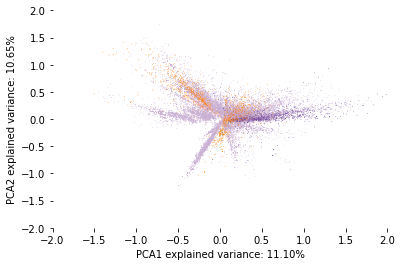

In [12]:
#PCA Levenshtein
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x=x_axis, y=y_axis, data=XY, hue='labels_dist', linewidth=0, legend=False, palette=cp, s=0.5)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.savefig('pcaLevenshtein.pdf')

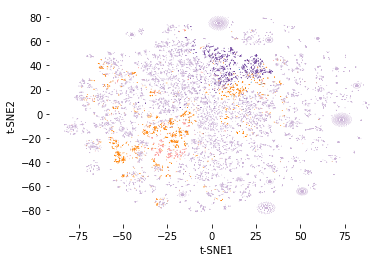

In [13]:
#t-SNE Levenshtein
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x='t-SNE1', y='t-SNE2', data=XY, hue='labels_dist', linewidth=0, legend=False, palette=cp, s=0.5)
ax.set_frame_on(False)
plt.savefig('tsneLevenshtein.pdf')

# Epitope Filtering

In [14]:
filt = XY['seqAGEpitope'].isin(XY['seqAGEpitope'].value_counts().iloc[0:10].reset_index()['index'])
epitopedf = XY[filt].reset_index(drop=True)
epitopedf['seqAGEpitope'].value_counts()

V3D3Q2R2      10386
V2V3T2L2       7775
D2Q3           3737
L2D2Q3          947
D2V2V2Q3        904
F2V3D3Q2R2      313
T3L2            248
V3Q2Q2V2K2      216
L3Y2R2L2        183
L2L3R2           62
Name: seqAGEpitope, dtype: int64

In [15]:
epitopedf.isnull().values.any()

False

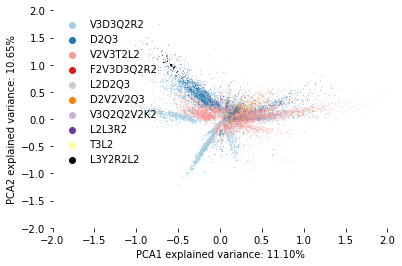

In [16]:
#PCA epitope scatter
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x=x_axis, y=y_axis, data=epitopedf, hue='seqAGEpitope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.legend(loc='upper left', frameon=False)
plt.savefig('pca_epitope.pdf')

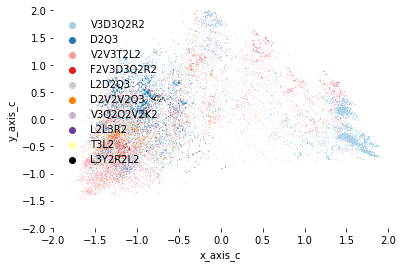

In [17]:
#PCA Controll
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x='x_axis_c', y='y_axis_c', data=epitopedf, hue='seqAGEpitope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.legend(loc='upper left', frameon=False)
plt.savefig('pca_control_epitope.png', dpi=500)

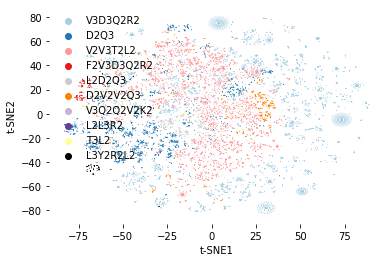

In [18]:
#t-SNE Epitope scatter
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x='t-SNE1', y='t-SNE2', data=epitopedf, hue='seqAGEpitope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
plt.legend(loc='upper left', frameon=False)
plt.savefig('tsne_epitope.pdf')

In [29]:
#epitopedf

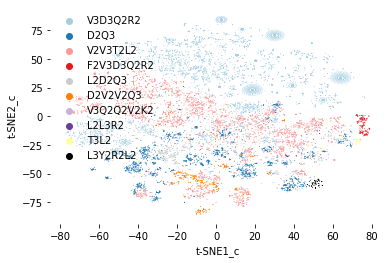

In [20]:
#t-SNE controll
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x='t-SNE1_c', y='t-SNE2_c', data=epitopedf, hue='seqAGEpitope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
plt.legend(loc='upper left', frameon=False)
plt.savefig('tsne_control_epitope.png', dpi=500)

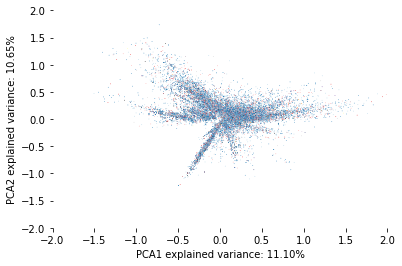

In [21]:
#shuffeled baseline epitope
epitopedf['seqAGEpitope'] = np.random.permutation(epitopedf['seqAGEpitope'].values)
plt.clf()
cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x=x_axis, y=y_axis, data=epitopedf, hue='seqAGEpitope', linewidth=0, palette=cp, s=0.5, legend=False)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
#plt.legend(loc='upper left', frameon=False)
plt.savefig('pca_baseline_epitope.pdf')

 # Paratope Mask

In [22]:
filt = XY['interMaskABParatope'].isin(XY['interMaskABParatope'].value_counts().iloc[0:10].reset_index()['index'])
paratopedf = XY[filt].reset_index(drop=True)
paratopedf['interMaskABParatope'].value_counts()

21021111111    8014
11111111111    3542
11111011011    3375
21221111011    1907
11011111101    1873
10111111011    1342
10111111111     914
11111111110     662
11001111111     609
11111111101     414
Name: interMaskABParatope, dtype: int64

In [23]:
paratopedf.isnull().values.any()

False

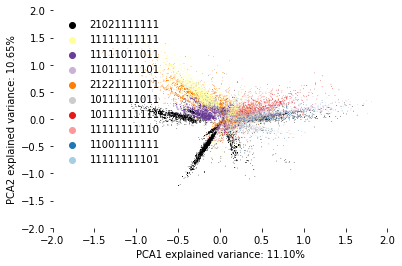

In [24]:
#PCA paratope scatter
plt.clf()
c_list = ['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000']
cp = sns.color_palette(list(reversed(c_list)))
ax = sns.scatterplot(x=x_axis, y=y_axis, data=paratopedf, hue='interMaskABParatope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.legend(loc='upper left', frameon=False)
plt.savefig('pca_paratope.pdf')

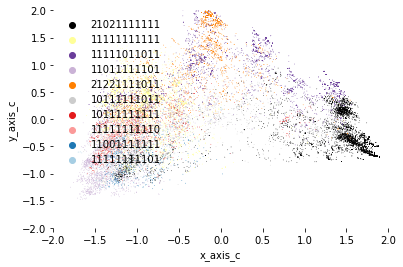

In [25]:
#PCA paratope controll
plt.clf()
c_list = ['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000']
cp = sns.color_palette(list(reversed(c_list)))
ax = sns.scatterplot(x='x_axis_c', y='y_axis_c', data=paratopedf, hue='interMaskABParatope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.legend(loc='upper left', frameon=False)
plt.savefig('pca_paratope_control.png', dpi=500)

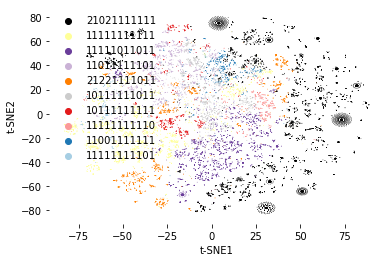

In [26]:
#t-SNE paratope scatter
plt.clf()
#cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x='t-SNE1', y='t-SNE2', data=paratopedf, hue='interMaskABParatope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
plt.legend(loc='upper left', frameon=False)
plt.savefig('tsne_paratope.pdf')

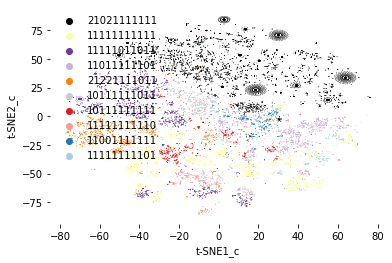

In [27]:
#t-SNE paratope controll
plt.clf()
#cp = sns.color_palette(['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000'])
ax = sns.scatterplot(x='t-SNE1_c', y='t-SNE2_c', data=paratopedf, hue='interMaskABParatope', linewidth=0, palette=cp, s=0.5)
ax.set_frame_on(False)
plt.legend(loc='upper left', frameon=False)
plt.savefig('tsne_paratope_control.png', dpi=500)

No handles with labels found to put in legend.


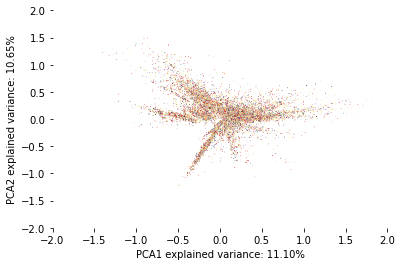

In [28]:
#shuffeled baseline paratope
paratopedf['interMaskABParatope'] = np.random.permutation(paratopedf['interMaskABParatope'].values)
plt.clf()
c_list = ['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000']
cp = sns.color_palette(list(reversed(c_list)))
ax = sns.scatterplot(x=x_axis, y=y_axis, data=paratopedf, hue='interMaskABParatope', linewidth=0, palette=cp, s=0.5, legend=False)
ax.set_frame_on(False)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
plt.legend(loc='upper left', frameon=False)
plt.savefig('pca_baseline_paratope.pdf')

# Heatmap Levenshtein vs. Epitope

In [ ]:
#c_replace2 = {'Ag126':'#a6cee3', 'Ag18':'#1f78b4', 'Ag34':'#fb9a99', 'Ag44':'#e31a1c', 'Ag63':'#cccccc', 'Ag80':'#ff7f00', 'Ag88':'#cab2d6', 'Ag93':'#ffff99', 'Ag98':'#000000'}
#c_replace = {'11':'#a6cee3', '17':'#1f78b4', '23':'#fb9a99', '16':'#e31a1c', '5':'#fdbf6f', '6':'#ff7f00', '21':'#cab2d6', '10':'#6a3d9a', '9':'#ffff99', '19':'#000000', '13':'#b15928', '15':'#b2df8a', '7':'#33a02c', '2':'#0000ff', '22':'#cccccc', '14':'#999999', '12':'#660000', '1':'#990000', '8':'#996600', '18':'#ff00cc', '20':'#ffff00', '3':'#ff66ff', '4':'#99ff00'}
levenshteinC = ['#a6cee3', '#1f78b4', '#fb9a99', '#e31a1c', '#cccccc', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#000000']
c_replace = {i:j for i, j in enumerate(levenshteinC, start=1)}
XY['creplace'] = XY['labels_dist'].replace(c_replace)

In [ ]:
epi_map = {'V3D3Q2R2':'#a6cee3', 'D2Q3':'#1f78b4', 'V2V3T2L2':'#fb9a99', 'F2V3D3Q2R2':'#e31a1c', 'L2D2Q3':'#cccccc', 'D2V2V2Q3':'#ff7f00', 'V3Q2Q2V2K2':'#cab2d6', 'L2L3R2':'#6a3d9a', 'T3L2':'#ffff99', 'L3Y2R2L2':'#000000'}
XY['epireplace'] = XY['seqAGEpitope'].map(epi_map).fillna('#7F7F7F')
XY.isnull().values.any()

In [ ]:
plt.clf()
subN = 500
distmat_t = distmat[0:subN, 0:subN]
linkage_t = scipy.cluster.hierarchy.linkage(scipy.spatial.distance.squareform(distmat_t), method='average')
#g = sns.clustermap(distmat_t, row_linkage=linkage, col_linkage=linkage, yticklabels=False, xticklabels=False, row_colors=XY['creplace2'][0:subN].to_numpy(), col_colors=XY['creplace'][0:subN].to_numpy())
g = sns.clustermap(distmat_t, row_linkage=linkage_t, col_linkage=linkage_t, yticklabels=False, xticklabels=False, col_colors=XY['creplace'][0:subN].to_numpy(), row_colors=XY['epireplace'][0:subN].to_numpy())
g.ax_heatmap.tick_params(left=False, bottom=False, right=False)
g.ax_row_dendrogram.set_visible(False)
#plt.savefig('Epitopeclustermap.pdf')

# Heatmap Levenshtein vs. Paratope

In [ ]:
t = {'21021111111':'#000000',
     '11111111111':'#ffff99',
     '11111011011':'#6a3d9a',
     '11011111101':'#cab2d6',
     '21221111011':'#ff7f00',
     '10111111011':'#cccccc',
     '10111111111':'#e31a1c',
     '11111111110':'#fb9a99',
     '11001111111':'#1f78b4',
     '11111111101':'#a6cee3'}
XY['parareplace'] = XY['interMaskABParatope'].map(epi_map).fillna('#7F7F7F')
XY.isnull().values.any()

In [ ]:
plt.clf()
subN = 500
distmat_t = distmat[0:subN, 0:subN]
#g = sns.clustermap(distmat_t, row_linkage=linkage, col_linkage=linkage, yticklabels=False, xticklabels=False, row_colors=XY['creplace2'][0:subN].to_numpy(), col_colors=XY['creplace'][0:subN].to_numpy())
g = sns.clustermap(distmat_t, row_linkage=linkage_t, col_linkage=linkage_t, yticklabels=False, xticklabels=False, col_colors=XY['creplace'][0:subN].to_numpy(), row_colors=XY['parareplace'][0:subN].to_numpy())
g.ax_heatmap.tick_params(left=False, bottom=False, right=False)
g.ax_row_dendrogram.set_visible(False)
#plt.savefig('PAratopeclustermap.pdf')